In [1]:
import numpy as np
import scipy as sp
from scipy import linalg
import matplotlib.pyplot as plt


This notebook will help you get started with project 1. You do not have too use any of this code in your answers and you can change the code however you want, but if you include any code used here in your answers refer to it as "handed out code".

The below code generates a full rank $m \times n$ matrix $A$ that has correlated columns. This can be useful for simulating linear regression datasets. You can pretend that the code generates $m$ datapoints with $n$ covariates, and you want to do linear regression on this dataset. How we generate this matrix is not of interest in this project.

What is of interest is the values you choose for $m$ and $n$. In this notebook we select $m = 2048$ and $n = 8096$, which is not too large, but can still make the numerical algorithms slow on some older computers. Storing this matrix requires about $128$ megabytes of RAM, which is not a lot on modern computers, but you can take some time to appreciate that this would not have been possible on computers $20-30$ years ago. For this project you can try some different values for $m$ and $n$, but for small systems you don't really have to use anything other than ```np.linalg.solve``` (which is more or less a really optimized LU factorization) or ```np.linalg.inv``` to solve your problems. It is only for large problems that numerical linear algebra really becomes interesting, and we have to apply some methods that we will apply in this project.

In [2]:
# Generate matrix A \in \mathbb{R}^{m \times n}

def generate_A(m,n):
    """
    Generates m times n with correlated columns.
    Input:
        m: int, first dimension of A
        n: int, second dimension of A
    output:
        A: (m,n) array
    """

    cov_eigvecs = np.random.uniform(-1.0,1.0,(m,m))
    cov = cov_eigvecs.T @ cov_eigvecs
    v = np.sqrt(np.diag(cov))
    outer_v = np.outer(v, v)
    corr = cov / outer_v
    corr[cov == 0] = 0
    chol = sp.linalg.cholesky(corr, lower=True) 
    A = np.random.normal(0, 1.0,(m,n))
    A = np.dot(chol, A)
    return A

m = 2048
n = 8096
A = generate_A(m,n)

Task 1
---

Below code generates $\mathbf{x}$ and $\mathbf{y}$ for linear systems, which you will need in the final subtask of Task 1.

In [3]:
N = 100 # Number of test data we want to generate

# Generate solutions X columnwise, X[:,i] to access i-th vector
X = np.random.normal(0.0,1.0,(A.shape[1],N))

# Generate left hand sides Y columnwise Y[:,i] to access lhs
Y = np.dot(A,X)

# Doublecheck shapes
print(X.shape) # Expect (n,N)
print(Y.shape) # Expect (m,N)

(8096, 100)
(2048, 100)


In Jupyter notebooks you can use ```%timeit``` to time a line of code or ```%%timeit``` to time a chunk of code.
I find the latter easier to use. These functions usually runs the code many times and provide. You can select the number of times you want to run the code using the ```-r``` option. In the chunks below, we run the code $5$ times in order to got a standard deviation of our runtime. Jupyter notebooks also time how long it takes to run a chunk, but this timing is a lot more unreliable, so do not use this for reporting timing results. Make sure that when you time your code you do as little else as possible on your computer, that is: close all irrelevant programs and make sure to not minimize the window where the code is run as this might lower the priority of running the code on your computer.

Let us time the difference between calculating $A^TA$ and $AA^T$ for our given matrix. We expect the latter operation to be faster given our "wide" matrix.

In [4]:
%%timeit -r 5
ATA = np.dot(A.T,A)

1.95 s ± 200 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [5]:
%%timeit -r 5
AAT = np.dot(A, A.T)

463 ms ± 8.5 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


Note that calculating $AA^T$ is much cheaper than calculating $A^TA$, because the matrix $A$ is "wide".

Let us now try to test the minimal norm solution using ```np.linalg.solve``` for our test data. We calculate the minimal norm solution for all our test data, including the time it takes to calculate $AA^T$ once. Because this is a relatively large experiment, we only run this code once.
You will have to run this on your own computer to compare against your QR implementation.

You should also pass the option ```-n 1``` to make sure that the code only runs once.

In [6]:
%%timeit -r 1 -n 1
AAT = np.dot(A, A.T)
for i in range(N):
    z = np.linalg.solve(AAT,Y[:,i])
    x_sol = np.dot(A.T,z)

15.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Task 2
---

The below code calculates the SVD with and without ```full_matrices = False```
to show how much time we can save.

In [7]:
%%timeit -r 1 -n 1
U,S,Vt = np.linalg.svd(A)
print(U.shape) # Expect (m,m)
print(S.shape) # Expect (m)
print(Vt.shape) # Expect (n,n) A lot of redundant vectors!

(2048, 2048)
(2048,)
(8096, 8096)
24.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [8]:
%%timeit -r 1 -n 1
U,S,Vt = np.linalg.svd(A,full_matrices = False)
print(U.shape) # Expect (m,m)
print(S.shape) # Expect (m)
print(Vt.shape) # Expect (m,n) A lot less redundant vectors!

(2048, 2048)
(2048,)
(2048, 8096)
20.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


That's alotta ~~damage~~ timesave, as we don't have to calculate $8192 - 2048$ extra singular vectors. 

Task 3
---

Below code loads $100$ example mixed images stored in ```mixed.npy``` as an $784 \times 100$ array, and shows you how you can plot two example images. The file should be placed in a folder named ```Data``` in the folder where you have this notebook. You have to reshape the $784$ array into a $28 \times 28$ array to plot the image. We recommend using the ```gray``` colormap. 

(784, 100)


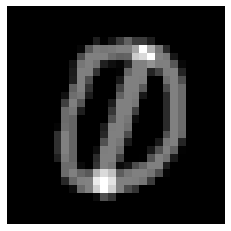

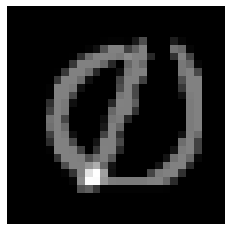

In [9]:
Mixes = np.load('Data/mixed.npy')
print(Mixes.shape) # Should be (784,100)

plt.imshow(Mixes[:,1].reshape((28,28)), cmap = 'gray')
plt.axis('off') # Removes the x and y axis to plot only the image
plt.show()

plt.imshow(Mixes[:,32].reshape((28,28)), cmap = 'gray')
plt.axis('off') # Removes the x and y axis to plot only the image
plt.show()

The below code loads the two matrices containing the basis vectors $W_0$ and $W_1$. We plot the first basis vector of $W_0$ to show that it more or less looks like a zero-digit. $W_0$ and $W_1$ are supposed to have orthogonal columns, so we should have $W_0^T W_0 = I$. We check if this is the case calculating $W_0^T W_0$ and using ```plt.imshow``` to see if this is (roughly) the identity matrix. 

(784, 16)
(784, 16)


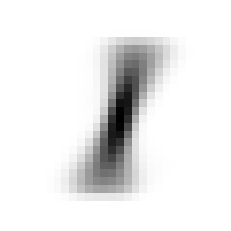

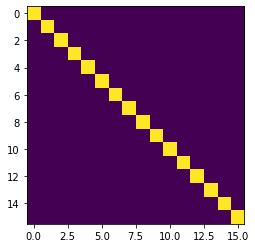

In [13]:
W0 = np.load('Data/W0.npy')
W1 = np.load('Data/W1.npy')
print(W0.shape) # Should be (784,16)
print(W1.shape) # Should be (784,16)

plt.imshow(W1[:,0].reshape((28,28)), cmap = 'gray')
plt.axis('off')
plt.show()

W0TW0 = np.dot(W0.T, W0)
plt.imshow(W0TW0)
plt.show()